In [1]:
import os
import numpy as np
import pandas as pd
import json
import itertools
import pickle
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer, util

## Prepare data

In [2]:
source_path = '/home/mzhang01/google_2022/produce_complete_data/05-assemble-final-results'

In [3]:
'''
Import the var table with sets info
'''
var = pd.read_csv(os.path.join(source_path, 'g2022_adid_var_sets_072024.csv.gz'))

### Subset for general election period data
Sept 2022 - Nov 2022

In [4]:
condition = (var.date_range_end >= '2022-09-01') & (var.date_range_start <= '2022-11-30')
'''
Second condition is not necessary: resulting dataframe shapes are the same.
'''

var = var[condition]

In [5]:
var.shape

(86140, 75)

### Filter for set 3 and select only the confirmed Senate/House races

In [6]:
'''
Set 3
'''
var = var.loc[var.set3 == 1]

In [7]:
var.shape

(33838, 75)

In [8]:
var[~var.race_of_focus.isin(['No race of focus', 'Downballot'])].sub_bucket.unique()

array(['3.1', '3.2.2.3', '1'], dtype=object)

In [9]:
var.sub_bucket.unique()

array(['3.1', '3.3', '3.2.2.3', '2', '1'], dtype=object)

In [10]:
'''
Only house/senate races 
'''
# condition2 = var.wmp_spontype.isin(['campaign', 'group', 'party', 'party national']) & ((var.wmp_sen == 1) | (var.wmp_hse == 1))
# condition2 =  (var.wmp_sen == 1) | (var.wmp_hse == 1) | (var.wmp_office == 'us senate') | (var.wmp_office == 'us house')
condition2 = (var.wmp_sen == 1) | (var.wmp_hse == 1) | (var.wmp_office == 'us senate') | (var.wmp_office == 'us house') | (~var.race_of_focus.isin(['No race of focus', 'Downballot']))

In [11]:
var = var[condition2]

In [237]:
var.shape

(28030, 75)

In [12]:
var.groupby(['wmp_spontype']).size()

wmp_spontype
campaign                     14050
government agency               77
government official            105
group                         8570
party                          496
party national                1558
unclear could be campaign      329
dtype: int64

### Import text and ad-cid mapping tables

In [13]:
'''
Import "text" table to get "ad_type"

'''
text = pd.read_csv(os.path.join(source_path, 'g2022_adid_01062021_11082022_text_v20240115.csv.gz'),
                   usecols=['ad_id', 'ad_type', 'advertiser_name'])

In [14]:
'''
Merge with text fields
'''
var = var.merge(text, how='left', on='ad_id').drop_duplicates()

In [15]:
var.shape

(28131, 77)

In [16]:
'''
Import "cid" to "ad_id" mapping
'''
cid_table_path = '../../../google_2022/produce_complete_data/04-dedup-2nd-time/final_output/cid_google2022_v20231203.csv'
cid = pd.read_csv(cid_table_path)

In [17]:
'''
Merge with cids
'''
var = var.merge(cid, how='left', on='ad_id').drop_duplicates()

In [18]:
len(cid.wmp_creative_id.unique())

64819

In [19]:
var.shape

(30296, 78)

In [20]:
len(var.wmp_creative_id.unique())

10602

In [47]:
var.columns

Index(['ad_id', 'advertiser_id', 'date_range_start', 'date_range_end',
       'num_of_days', 'impressions', 'age_targeting', 'gender_targeting',
       'geo_targeting_included', 'geo_targeting_excluded',
       'spend_range_min_usd', 'spend_range_max_usd', 'aws_face_vid',
       'aws_face_img', 'sub_bucket', 'race_of_focus', 'ad_tone_constructed',
       'ad_tone_mentionbased', 'goal_DONATE_prediction',
       'goal_DONATE_predicted_prob', 'goal_CONTACT_prediction',
       'goal_CONTACT_predicted_prob', 'goal_PURCHASE_prediction',
       'goal_PURCHASE_predicted_prob', 'goal_GOTV_prediction',
       'goal_GOTV_predicted_prob', 'goal_EVENT_prediction',
       'goal_EVENT_predicted_prob', 'goal_POLL_prediction',
       'goal_POLL_predicted_prob', 'goal_GATHERINFO_prediction',
       'goal_GATHERINFO_predicted_prob', 'goal_LEARNMORE_prediction',
       'goal_LEARNMORE_predicted_prob', 'goal_PRIMARY_PERSUADE_prediction',
       'goal_PRIMARY_PERSUADE_predicted_prob', 'goal_highest_prob',
 

### Import creative ids with nan text fields and remove nan values

In [60]:
# txt = pd.read_csv(source_path + '04-dedup-2nd-time/other_output/g2022_adid_merged_txt_lite_table.csv')

In [69]:
# nan_ids = set(txt[pd.isna(txt.txt_lite)].wmp_creative_id.to_list())

In [73]:
# pd.DataFrame({'nan_cid': list(nan_ids)}).to_csv('input_data/nan_cids.csv', index=False)

In [21]:
nan_ids = set(pd.read_csv('../input_data/nan_cids.csv').nan_cid.to_list())

In [22]:
'''
Remove nan text values
'''
var = var[var.wmp_creative_id.apply(lambda x: x not in nan_ids)]

In [23]:
var.shape

(30238, 78)

### Aggregate data at sponsor-media level 

#### Federal candidates: House/Senate

In [24]:
# maybe should only do this for fed candidates
var_cand = var[var.federal_cd==1]
# only campaign type is remaining after filtering

In [207]:
cols = ['advertiser_id', 'wmp_creative_id', 'ad_type']

In [208]:
cand_sponsor_agg = var_cand[cols].groupby(['advertiser_id', 'ad_type', 'wmp_creative_id']).first().reset_index().groupby(['advertiser_id', 'ad_type']).agg(lambda x: ' '.join(x)).reset_index()

In [209]:
cand_sponsor_agg.head(2)

,advertiser_id,ad_type,wmp_creative_id
0,AR00053674171938373633,TEXT,cid_36651 cid_36652 cid_36654 cid_36655 cid_36...
1,AR00053674171938373633,VIDEO,cid_36666 cid_36667 cid_36668 cid_36669


In [210]:
cand_sponsor_agg.rename(columns={'wmp_creative_id':'cids'}, inplace=True)

In [213]:
cand_sponsor_agg['num_unique'] = cand_sponsor_agg.cids.apply(lambda x: len(x.split()))

In [265]:
cand_sponsor_agg = cand_sponsor_agg[cand_sponsor_agg.num_unique > 1]

#### Non-campaign sponsors: Advertiser-media-race_of_focuse-level aggregation

In [217]:
var[var.federal_cd == 0].wmp_spontype.unique()

array(['group', 'unclear could be campaign', 'party national',
       'government agency', 'party', 'government official', 'campaign'],
      dtype=object)

In [219]:
var[var.federal_cd == 0].wmp_office.unique()

array([nan, 'us senate', 'us house', 'us house - other cycle',
       'us senate - other cycle'], dtype=object)

In [228]:
var[(var.federal_cd == 0) & (var.wmp_spontype == 'government agency')][['race_of_focus', 'advertiser_name', 'ad_type']]

,race_of_focus,advertiser_name,ad_type
29,PA08,US House of Representatives,TEXT
259,VA07,US HOUSE OF REPRESENTATIVES,TEXT
557,PA08,US HOUSE OF REPRESENTATIVES,TEXT
2770,NaN,US HOUSE OF REPRESENTATIVES,VIDEO
2878,AZ00,STATE OF ARIZONA,IMAGE
...,...,...,...
27671,PA07,US House of Representatives,TEXT
27970,NJ06,US HOUSE OF REPRESENTATIVES,TEXT
28260,CA07,US House of Representatives,TEXT
28395,CA07,US HOUSE OF REPRESENTATIVES,TEXT


##### Eliminate irrelevant offices among non-candidate campaign sponsors

In [242]:
condition3 = (var.federal_cd == 0) & (~var.wmp_office.isin(['us house - other cycle', 'us senate - other cycle']))
var_noncand = var[condition3]

In [243]:
var_noncand.shape

(12712, 78)

In [250]:
'''
Drop no race of focus and NAs
'''
var_noncand = var_noncand[~pd.isna(var_noncand.race_of_focus)]

In [254]:
var_noncand = var_noncand[var_noncand.race_of_focus != 'No race of focus']

In [255]:
var_noncand.shape

(9643, 78)

In [258]:
cols2 = ['advertiser_id', 'wmp_creative_id', 'ad_type', 'race_of_focus']

In [259]:
noncand_sponsor_agg = var_noncand[cols2].groupby(['advertiser_id', 'ad_type', 'race_of_focus', 'wmp_creative_id']).first().reset_index()\
.groupby(['advertiser_id', 'ad_type', 'race_of_focus']).agg(lambda x: ' '.join(x)).reset_index()

In [262]:
noncand_sponsor_agg.rename(columns={'wmp_creative_id':'cids'}, inplace=True)
noncand_sponsor_agg['num_unique'] = noncand_sponsor_agg.cids.apply(lambda x: len(x.split()))

# filter for sponsors with at least a pair of unique creatives
noncand_sponsor_agg = noncand_sponsor_agg[noncand_sponsor_agg.num_unique > 1]

In [263]:
noncand_sponsor_agg.head()

,advertiser_id,ad_type,race_of_focus,cids,num_unique
0,AR00035659773428891649,IMAGE,LA00,cid_5428 cid_5432,2
3,AR00170851600011624449,IMAGE,MD01,cid_650 cid_652,2
4,AR00170851600011624449,VIDEO,MD01,cid_650 cid_652,2
5,AR00281394781081305089,VIDEO,CA13,cid_44152 cid_44153 cid_44156 cid_44158,4
8,AR00315727375255994369,VIDEO,KS03,cid_51543 cid_51544 cid_51545 cid_51546 cid_51...,11


## Import corpus embedding model (indices reordered version)

In [98]:
corpus_embeddings = torch.load('../model/corpus_embedding_google2022_unique_lite_reordered.pt')

## compute pairwise cosine similarity
**Save average and standard deviation**

In [94]:
def compute_avg_similarity(cid_lst):
    cid_lst = cid_lst.split()
    
    pairs = list(itertools.combinations(cid_lst, 2))
    if pairs:
        scores = []
        for pair in pairs: 
            cid1, cid2 = pair
            idx1 = int(cid1.lstrip('cid_'))
            idx2 = int(cid2.lstrip('cid_'))
            
            score = util.cos_sim(corpus_embeddings[idx1], corpus_embeddings[idx2])[0][0].numpy()
            scores.append(score)
        return np.array(scores).mean(), np.array(scores).std()
    return None

### Federal candidates: by advertiser and media type

In [212]:
cand_sponsor_agg.loc[:, ['avg', 'std']] = cand_sponsor_agg.cids.apply(lambda x: pd.Series(compute_avg_similarity(x), index=['avg', 'std'], dtype="float"))

In [214]:
# Not necessary if dropping num_unique == 1 first
# cand_sponsor_agg = cand_sponsor_agg.dropna(subset=['avg'])

In [216]:
# adv_agg.to_csv('output_data/g2022_set3_advertiser_media_level_average_pairwise_similarity.csv', index=False)

'''
general election period only: Sept - Nov 2022
'''

cand_sponsor_agg.to_csv('../output_data/g2022_set3_gen_elect_cand_media_level_average_pairwise_similarity.csv', index=False)

### non-campaign candidate sponsors: by sponsor - media - race of focus

In [268]:
noncand_sponsor_agg.loc[:, ['avg', 'std']] = noncand_sponsor_agg.cids.apply(lambda x: pd.Series(compute_avg_similarity(x), index=['avg', 'std'], dtype="float"))

/tmp/ipykernel_17290/4056042535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noncand_sponsor_agg.loc[:, ['avg', 'std']] = noncand_sponsor_agg.cids.apply(lambda x: pd.Series(compute_avg_similarity(x), index=['avg', 'std'], dtype="float"))


In [269]:
noncand_sponsor_agg.shape

(688, 7)

In [271]:
noncand_sponsor_agg.num_unique.max()

32

In [273]:
'''
general election period only
'''
noncand_sponsor_agg.to_csv('../output_data/g2022_set3_gen_elect_noncandidate_advertiser_racefocus_media_level_average_pairwise_similarity.csv', index=False)

## Pairwise similarity distribution for individual candidate cases - legacy code

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
'''
general election period
'''
adv_agg = pd.read_csv('output_data/g2022_set3_gen_elect_advertiser_media_level_average_pairwise_similarity.csv')

In [15]:
adv_agg.head()

,advertiser_id,ad_type,cids,num_unique,avg,std
0,AR00037003582796464129,VIDEO,cid_26157,1,NaN,NaN
1,AR00038755998172708865,TEXT,cid_27308,1,NaN,NaN
2,AR00038755998172708865,VIDEO,cid_27309 cid_27310,2,0.529849,0.000000
3,AR00042500385021100033,IMAGE,cid_20424 cid_20425 cid_20426,3,0.740031,0.051164
4,AR00053674171938373633,TEXT,cid_36651 cid_36652 cid_36654 cid_36655 cid_36...,11,0.383467,0.200512


In [8]:
def compute_pairwise_similarity_adv_id(df, adv_id, media_type):
    
    cid_lst= df[(df.advertiser_id == adv_id) & (df.ad_type == media_type)].cids.iloc[0]
    
    cid_lst = cid_lst.split()
    
    pairs = list(itertools.combinations(cid_lst, 2))
    
    if pairs:
        scores = []
        for pair in pairs: 
            cid1, cid2 = pair
            idx1 = int(cid1.lstrip('cid_'))
            idx2 = int(cid2.lstrip('cid_'))
            
            score = util.cos_sim(corpus_embeddings[idx1], corpus_embeddings[idx2])[0][0].numpy()
            scores.append(float(score))
        return scores
    return None

[Text(0.5, 1.0, 'Pairwise text similarity distribution (text): Raphael Warnock'),
 Text(0.5, 0, 'similarity score')]

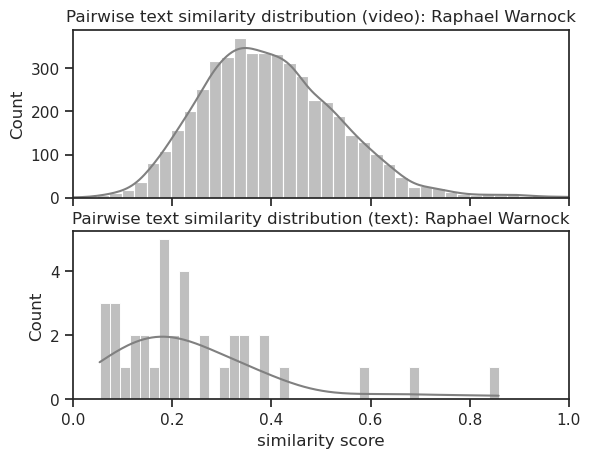

In [17]:
# Warnock general election

warnock_vid = compute_pairwise_similarity_adv_id(adv_agg, 'AR07182956219827486721', 'VIDEO')
warnock_txt = compute_pairwise_similarity_adv_id(adv_agg, 'AR07182956219827486721', 'TEXT')

sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(warnock_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(warnock_txt, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Raphael Warnock', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (text): Raphael Warnock', xlabel='similarity score')

In [12]:
# Warnock
adv_agg[adv_agg.advertiser_id == 'AR07182956219827486721']

,advertiser_id,ad_type,cids,avg,std,num_unique
1434,AR07182956219827486721,TEXT,cid_62966 cid_62967 cid_62969 cid_62970 cid_62...,0.274865,0.186229,11
1435,AR07182956219827486721,VIDEO,cid_62968 cid_62978 cid_62979 cid_62980 cid_62...,0.394246,0.141464,176


In [13]:
warnock_vid = compute_pairwise_similarity_adv_id(adv_agg, 'AR07182956219827486721', 'VIDEO')
warnock_txt = compute_pairwise_similarity_adv_id(adv_agg, 'AR07182956219827486721', 'TEXT')

[Text(0.5, 1.0, 'Pairwise text similarity distribution (text): Raphael Warnock'),
 Text(0.5, 0, 'similarity score')]

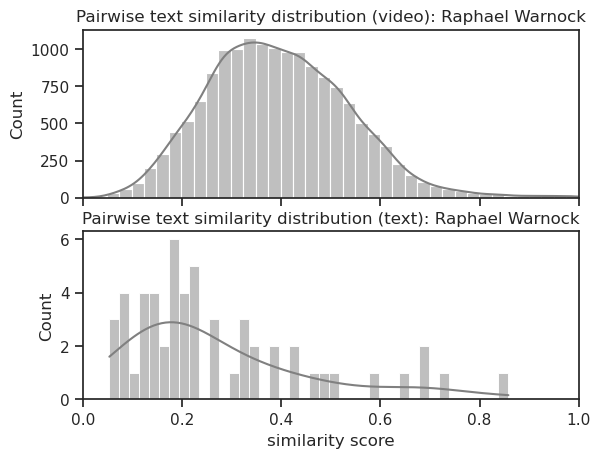

In [14]:
sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(warnock_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(warnock_txt, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Raphael Warnock', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (text): Raphael Warnock', xlabel='similarity score')

In [20]:
# AOC general election
adv_agg[adv_agg.advertiser_id == 'AR17095295161908330497']

,advertiser_id,ad_type,cids,num_unique,avg,std
1787,AR17095295161908330497,TEXT,cid_1081,1,NaN,NaN
1788,AR17095295161908330497,VIDEO,cid_1093 cid_1094 cid_1095 cid_1096 cid_1100 c...,10,0.559905,0.131457


[Text(0.5, 1.0, 'Pairwise text similarity distribution (text): Alexandria Ocasio-Cortez'),
 Text(0.5, 0, 'similarity score')]

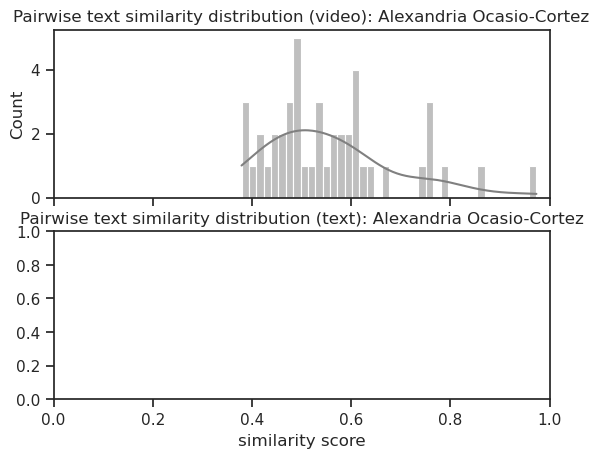

In [18]:
aoc_vid = compute_pairwise_similarity_adv_id(adv_agg, 'AR17095295161908330497', 'VIDEO')
aoc_txt = compute_pairwise_similarity_adv_id(adv_agg, 'AR17095295161908330497', 'TEXT')

sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(aoc_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(aoc_txt, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Alexandria Ocasio-Cortez', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (text): Alexandria Ocasio-Cortez', xlabel='similarity score')

In [15]:
# AOC
adv_agg[adv_agg.advertiser_id == 'AR17095295161908330497']

,advertiser_id,ad_type,cids,avg,std,num_unique
3241,AR17095295161908330497,TEXT,cid_1062 cid_1063 cid_1064 cid_1065 cid_1066 c...,0.468653,0.170634,31
3242,AR17095295161908330497,VIDEO,cid_1093 cid_1094 cid_1095 cid_1096 cid_1097 c...,0.452848,0.188370,13


In [17]:
aoc_vid = compute_pairwise_similarity_adv_id(adv_agg, 'AR17095295161908330497', 'VIDEO')
aoc_txt = compute_pairwise_similarity_adv_id(adv_agg, 'AR17095295161908330497', 'TEXT')

[Text(0.5, 1.0, 'Pairwise text similarity distribution (text): Alexandria Ocasio-Cortez'),
 Text(0.5, 0, 'similarity score')]

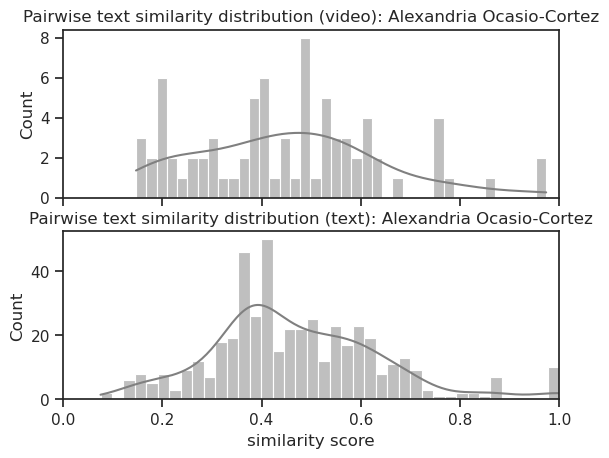

In [19]:
sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(aoc_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(aoc_txt, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Alexandria Ocasio-Cortez', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (text): Alexandria Ocasio-Cortez', xlabel='similarity score')

In [20]:
# Mark kelly
adv_agg[adv_agg.advertiser_id == 'AR03962319536304160769']

,advertiser_id,ad_type,cids,avg,std,num_unique
804,AR03962319536304160769,IMAGE,cid_37615 cid_37616 cid_37779 cid_37780,0.717371,0.141119,4
805,AR03962319536304160769,TEXT,cid_37555 cid_37556 cid_37557 cid_37558 cid_37...,0.377477,0.188067,59
806,AR03962319536304160769,VIDEO,cid_37573 cid_37617 cid_37618 cid_37619 cid_37...,0.448795,0.144620,164


[Text(0.5, 1.0, 'Pairwise text similarity distribution (text): Mark Kelly'),
 Text(0.5, 0, 'similarity score')]

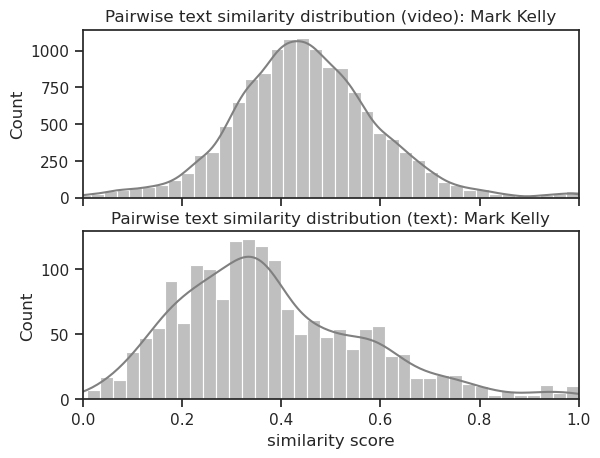

In [21]:
mkelly_vid = compute_pairwise_similarity_adv_id(adv_agg, 'AR03962319536304160769', 'VIDEO')
mkelly_txt = compute_pairwise_similarity_adv_id(adv_agg, 'AR03962319536304160769', 'TEXT')

sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(mkelly_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(mkelly_txt, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Mark Kelly', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (text): Mark Kelly', xlabel='similarity score')

In [22]:
# CATHERINE CORTEZ MASTO
adv_agg[adv_agg.advertiser_id == 'AR01112864509300572161']

,advertiser_id,ad_type,cids,avg,std,num_unique
235,AR01112864509300572161,TEXT,cid_8855 cid_8856 cid_8857 cid_8858 cid_8859 c...,0.298775,0.203163,56
236,AR01112864509300572161,VIDEO,cid_8911 cid_8912 cid_8913 cid_8914 cid_8915 c...,0.485873,0.139578,121


[Text(0.5, 1.0, 'Pairwise text similarity distribution (text): Catherine Cortez Masto'),
 Text(0.5, 0, 'similarity score')]

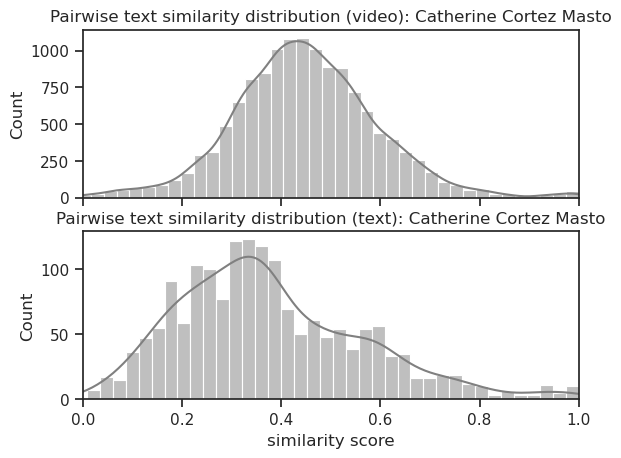

In [23]:
ccm_vid = compute_pairwise_similarity_adv_id(adv_agg, 'AR01112864509300572161', 'VIDEO')
ccm_txt = compute_pairwise_similarity_adv_id(adv_agg, 'AR01112864509300572161', 'TEXT')

sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(mkelly_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(mkelly_txt, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

ax[0].set(title='Pairwise text similarity distribution (video): Catherine Cortez Masto', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (text): Catherine Cortez Masto', xlabel='similarity score')